In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import torchxrayvision as xrv
import torchvision
from tqdm import tqdm
import sys

import skimage.io as io
from skimage.transform import  rescale,resize
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray
from skimage import exposure
import matplotlib.pyplot as plt

In [2]:
def test_dataloader_stats():
    # print stats
    for views in [["PA","AP"],["AP Supine"]]:
        print(xrv.datasets.COVID19_Dataset(views=views,
                                             imgpath="covid-chestxray-dataset/images",
                                             csvpath="covid-chestxray-dataset/metadata.csv"))
        
def test_dataloader():
    d_covid19 = xrv.datasets.COVID19_Dataset(views=["PA", "AP", "AP Supine"],
                                             imgpath="covid-chestxray-dataset/images",
                                             csvpath="covid-chestxray-dataset/metadata.csv")
    print(d_covid19)
    print(len(d_covid19))

    for i in tqdm(range(len(d_covid19))):
        # start from the most recent
        a = d_covid19[len(d_covid19)-i-1]
    return d_covid19

In [3]:
def min_max_shape(data):
    xmax, xmin, ymax, ymin = 0,10000,0,1000
    count_big=0
    count_small=0
    for d in data:
        _, x1, y1 = d.shape
        if x1>1000:
            count_big+=1
        if x1<400:
            count_small+=1
        if xmax < x1:
            xmax = x1
        if xmin > x1:
            xmin = x1
        if ymax < y1:
            ymax = y1
        if ymin > y1:
            ymin = y1
    return (xmin, ymin), (xmax, ymax), count_big, count_small\

def get_pad(target, current, i):
    p1 = int((target[i]-current.shape[1+i])/2)
    p2 = int((target[i]-current.shape[1+i]+1)/2)
    return p1, p2

In [4]:
def get_img(target, path, im):
    im = cv2.imread("{}/{}".format(path, im))
    ix = rgb2gray(im)
    newshape=np.min(ix.shape)
    mod = ix.shape-newshape
    if mod[0] > 0:
        x1=int(mod[0]/2)
        x2=ix.shape[0]-int(mod[0]/2+1)
        ix=ix[x1:x2,:]
    elif mod[1] > 0:
        y1=int(mod[1]/2)
        y2=ix.shape[1]-int(mod[1]/2+1)
        ix=ix[:, y1:y2]
    img_resized = resize(ix, target)#convert image size to 512*512
    img_rescaled=(img_resized-np.min(img_resized))/(np.max(img_resized)-np.min(img_resized))#min-max normalization 
    img_enhanced=exposure.equalize_adapthist(img_rescaled)#adapt hist
    img_resized_8bit=img_as_ubyte(img_enhanced)
    return img_resized_8bit

In [5]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(512)])

Setting XRayResizer engine to cv2 could increase performance.


In [6]:
d_covid19 = xrv.datasets.COVID19_Dataset(views=["PA", "AP", "AP Supine"],
                                             imgpath="covid-chestxray-dataset/images",
                                             csvpath="covid-chestxray-dataset/metadata.csv",
                                        transform=transform)

In [7]:
img_resized.shape

NameError: name 'img_resized' is not defined

In [9]:
X = []
y = []
cp=0
cn=0
target_shape=(512,512)
for i in tqdm(range(len(d_covid19))):
    img_resized = d_covid19[i]['img'].reshape(target_shape)
    img_rescaled=(img_resized-np.min(img_resized))/(np.max(img_resized)-np.min(img_resized))#min-max normalization 
    img_enhanced=exposure.equalize_adapthist(img_rescaled)#adapt hist
    img_resized_8bit=img_as_ubyte(img_enhanced)
    X.append(d_covid19[i]['img'])
    if d_covid19[i]["lab"][3] == 0:
        y.append(np.zeros((1,1)))
        cn+=1
        destination_dir="./covid_big_dset2/normal/"
        img_name="{}.jpeg".format(i)
    else:
        y.append(np.ones((1,1)))
        cp +=1
        destination_dir="./covid_big_dset2/covid/"
        img_name="{}.jpeg".format(i)
    io.imsave(os.path.join(destination_dir,img_name),img_resized_8bit)#save enhanced image to destination dir

100%|██████████| 697/697 [06:06<00:00,  4.41it/s]


In [10]:
print(len(X))
print(len(y))

697
697


In [11]:
shape_min, shape_max, count_big, count_small = min_max_shape(X)

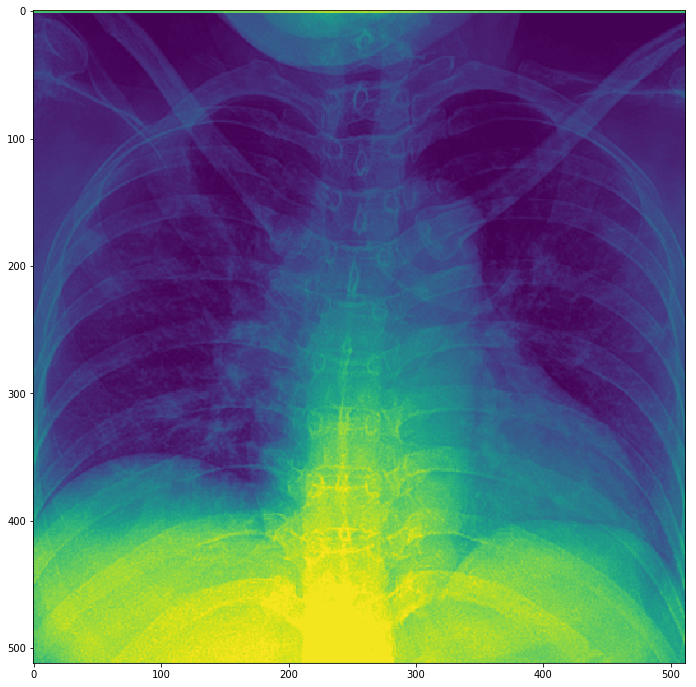

In [12]:
plt.figure(0, (18,12))
i=5
plt.imshow(np.reshape(X[i],(X[i].shape[1], X[i].shape[2])))

In [20]:
cp

478

In [21]:
cn

219

In [22]:
cp-cn

259

In [34]:
%%bash
ls /Users/qati/Downloads/chest_xray/train
mkdir covid_big_dset/pneumonia

NORMAL
PNEUMONIA


In [49]:
path="/Users/qati/Downloads/chest_xray/train/NORMAL"

In [50]:
imgs=os.listdir(path)

In [52]:
np.random.shuffle(imgs)

In [41]:
len(imgs)

1341

In [42]:
cp = 478-423

In [47]:
k=0

In [53]:
new_x = []
for i in tqdm(range(cp)):
    destination_dir="./covid_big_dset2/normal/"
    img_name="{}.jpeg".format(i+1204)
    img_path = os.path.join(destination_dir,img_name)
    if os.path.exists(img_path):
        k+=1
    img = get_img(target_shape, path, imgs[i])
    io.imsave(img_path,img)#save enhanced image to destination dir

100%|██████████| 55/55 [00:08<00:00,  6.92it/s]


In [21]:
for x in new_x:
    X.append(x)
    y.append(np.zeros((1,1)))

In [22]:
print(len(X))

956


In [23]:

;.l,≥÷print(len(y))

956


In [24]:
X[0].shape

(1, 1200, 1200)

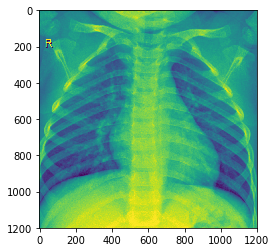

In [25]:
plt.imshow(X[850].reshape(target_shape))

In [26]:
npX = np.concatenate(X)

In [27]:
npY = np.concatenate(y)

In [28]:
npX.shape

(956, 1200, 1200)

In [18]:
len(os.listdir("./covid_big_dset2/normal"))

219

In [21]:
478-219

259

In [19]:
len(os.listdir("./covid_big_dset2/covid"))

478

In [20]:
len(os.listdir("./covid_big_dset2/pneumonia"))

478

In [29]:
%%bash

python3 ./extract_features.py

Traceback (most recent call last):
  File "./extract_features.py", line 12, in <module>
    from utils import*
ModuleNotFoundError: No module named 'utils'


CalledProcessError: Command 'b'\npython3 ./extract_features.py\n'' returned non-zero exit status 1.

In [43]:
a=[np.zeros((8,3)) for i in range (3)]

In [44]:
a

[array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])]

In [45]:
np.concatenate(a).shape

(24, 3)

In [56]:
import scipy.io as sio

In [57]:
sio.loadmat("./covid_big_dset2/covid.mat")

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Nov 28 15:44:26 2020',
 '__version__': '1.0',
 '__globals__': [],
 './covid_big_dset2/covid': array([[1.42473271e+05, 5.43577413e-01, 2.03912240e-01, ...,
         2.22825935e+01, 8.09864491e-02, 2.00000000e+00],
        [1.13673024e+05, 4.57162601e-01, 2.95422512e-01, ...,
         1.75108197e+02, 1.34911607e-01, 2.00000000e+00],
        [1.00113922e+05, 3.81908673e-01, 1.46567917e-01, ...,
         6.97310771e+01, 7.72970793e-02, 2.00000000e+00],
        ...,
        [1.59340275e+05, 6.08947603e-01, 2.41766728e-01, ...,
         4.95163969e+01, 8.31012295e-02, 2.00000000e+00],
        [1.78808412e+05, 6.82105163e-01, 2.24468877e-01, ...,
         8.15955696e+01, 7.46523954e-02, 2.00000000e+00],
        [1.42538529e+05, 5.50875673e-01, 2.33738760e-01, ...,
         3.89004110e+01, 7.89946753e-02, 2.00000000e+00]])}

In [68]:
%%bash
ls ./big_dset_smaller_img/

covid.mat
normal.mat
pneumonia.mat
test
train


In [73]:
def load(cls):
    return sio.loadmat("./big_dset_smaller_img/{}.mat".format(cls))[cls]

def save(m, cls):
    sio.savemat("./big_dset_smaller_img/{}.mat".format(path, cls), {cls: m})

In [72]:
n = load("normal")

In [75]:
n.shape

(478, 253)